# DINOv2
https://github.com/facebookresearch/dinov2

In [1]:
import torch
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from tqdm import tqdm

## モデル読み込み

In [2]:
model = torch.hub.load('facebookresearch/dinov2', 'dinov2_vits14')  # dinov2_vits14
print(type(model))
model

Using cache found in /Users/okazawa/.cache/torch/hub/facebookresearch_dinov2_main
/Users/okazawa/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
/Users/okazawa/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
/Users/okazawa/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")


<class 'dinov2.models.vision_transformer.DinoVisionTransformer'>


DinoVisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 384, kernel_size=(14, 14), stride=(14, 14))
    (norm): Identity()
  )
  (blocks): ModuleList(
    (0-11): 12 x NestedTensorBlock(
      (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (attn): MemEffAttention(
        (qkv): Linear(in_features=384, out_features=1152, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=384, out_features=384, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): LayerScale()
      (drop_path1): Identity()
      (norm2): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=384, out_features=1536, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=1536, out_features=384, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
      (ls2): LayerScale()
      (drop_path2): Identity()
    )
  )
  (n

## tSNE

In [3]:
# 画像前処理（リサイズ、クロップ、Tensor変換、正規化）
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

# ImageFolderでデータセットを読み込み
data_path = "data/InsPLAD-fault/defect_supervised/yoke-suspension/train"
dataset = ImageFolder(root=data_path, transform=transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=False, num_workers=4)

model.eval()

# GPUが利用可能ならGPUを使用
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# 特徴量とラベルの取得
features = []
labels = []
with torch.no_grad():
    for images, label in tqdm(dataloader):
        images = images.to(device)
        # 特徴抽出器を通して特徴量を取得（出力サイズは(batch_size, 2048, 1, 1)）
        output = model(images)
        # 出力をフラット化して(batch_size, 2048)の形に変換
        output = output.view(output.size(0), -1)
        features.append(output.cpu().numpy())
        labels.append(label.cpu().numpy())

# バッチごとの特徴量とラベルを連結
features = np.concatenate(features, axis=0)
labels = np.concatenate(labels, axis=0)

# t-SNEで2次元に次元削減（ランダムシードは再現性のため）
tsne = TSNE(n_components=2, random_state=42)
features_tsne = tsne.fit_transform(features)

100%|██████████| 19/19 [00:42<00:00,  2.26s/it]


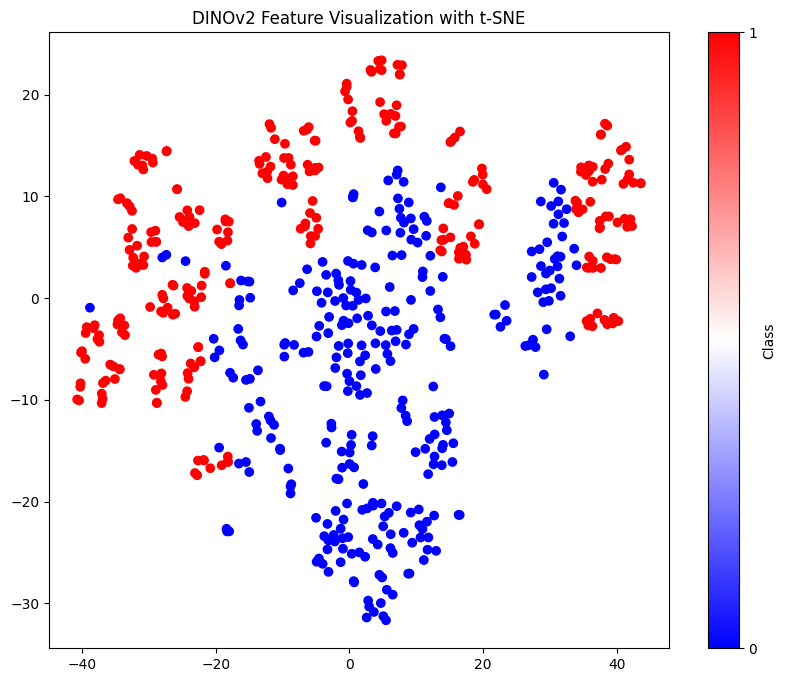

In [4]:
# 2次元空間での可視化
plt.figure(figsize=(10, 8))
scatter = plt.scatter(features_tsne[:, 0], features_tsne[:, 1], c=labels, cmap='bwr')
plt.colorbar(scatter, ticks=range(len(dataset.classes)), label='Class')
plt.title("DINOv2 Feature Visualization with t-SNE")
plt.show()

In [5]:
print("Num good:", (labels == 0).sum())
print("Num anomaly:", (labels == 1).sum())

Num good: 299
Num anomaly: 290
